In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from model import ImagePredictor
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt

import utils.data as data

ds = data.Datasets("/Users/henrywilliams/Documents/uni/amml/assessment/data")
n6 = ds.n6_full().numpy()

n6 = (n6 - n6.min()) / (n6.max() - n6.min())

BATCH_SIZE = 64
EPOCHS = 20

device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)

In [2]:
def create_dataset(data, idxs):
    dataset = []

    for sequence in data:
        for idx in idxs:
            dataset.append(sequence[idx])

    dataset = np.array(dataset)
    return dataset[:, :-1], dataset[:, -1]


idxs = np.array([[i + j for j in range(3)] for i in range(14)])

train_mask = np.isin(idxs, data.TEST_INDICIES)
test_mask = np.isin(idxs[:, -1], data.TEST_INDICIES)
train_idxs = idxs[~train_mask.any(axis=1)]
test_idxs = idxs[test_mask]

print(f"Train:\n{train_idxs}")
print(
    f"Test:\n{test_idxs}",
)
train_X, train_y = create_dataset(n6, train_idxs)
test_X, test_y = create_dataset(n6, test_idxs)

train_y = train_y.reshape(-1, 1, 36, 36, 1)
test_y = test_y.reshape(-1, 1, 36, 36, 1)

train_X = torch.tensor(train_X, dtype=torch.float32, device=device).permute(
    0, 4, 1, 2, 3
)
train_y = torch.tensor(train_y, dtype=torch.float32, device=device).permute(
    0, 4, 1, 2, 3
)
test_X = torch.tensor(test_X, dtype=torch.float32, device=device).permute(0, 4, 1, 2, 3)
test_y = torch.tensor(test_y, dtype=torch.float32, device=device).permute(0, 4, 1, 2, 3)

train = TensorDataset(train_X, train_y)
test = TensorDataset(test_X, test_y)

train_loader = DataLoader(train, BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, BATCH_SIZE, shuffle=True)

Train:
[[ 0  1  2]
 [ 4  5  6]
 [ 5  6  7]
 [ 6  7  8]
 [ 7  8  9]
 [ 8  9 10]
 [ 9 10 11]
 [10 11 12]
 [11 12 13]
 [12 13 14]]

Test:
[[ 1  2  3]
 [13 14 15]]

In [3]:
model = ImagePredictor(
    in_channels=1,
    num_kernels=64,
    kernel_size=(3, 3),
    padding=(1, 1),
    activation="relu",
    image_size=(36, 36),
    num_layers=4,
    device=device,
).to(device)

optim = Adam(model.parameters(), lr=1e-4)

criterion = nn.MSELoss()

train_losses = []
test_losses = []


for epoch in range(EPOCHS):
    model.train()
    for input, target in tqdm(
        train_loader,
        desc=f"Train epoch {epoch + 1}/{EPOCHS}",
        leave=False,
    ):
        output = model(input).unsqueeze(1)
        loss = criterion(output, target)
        loss.backward()
        optim.step()
        optim.zero_grad()
        train_losses.append(loss.item())

    test_loss = 0
    model.eval()
    for input, target in tqdm(
        test_loader,
        desc=f"Test epoch {epoch + 1}/{EPOCHS}",
        leave=False,
    ):
        with torch.no_grad():
            output = model(input).unsqueeze(1)
        loss = criterion(output, target)
        test_loss += loss.item()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

KeyboardInterrupt: 

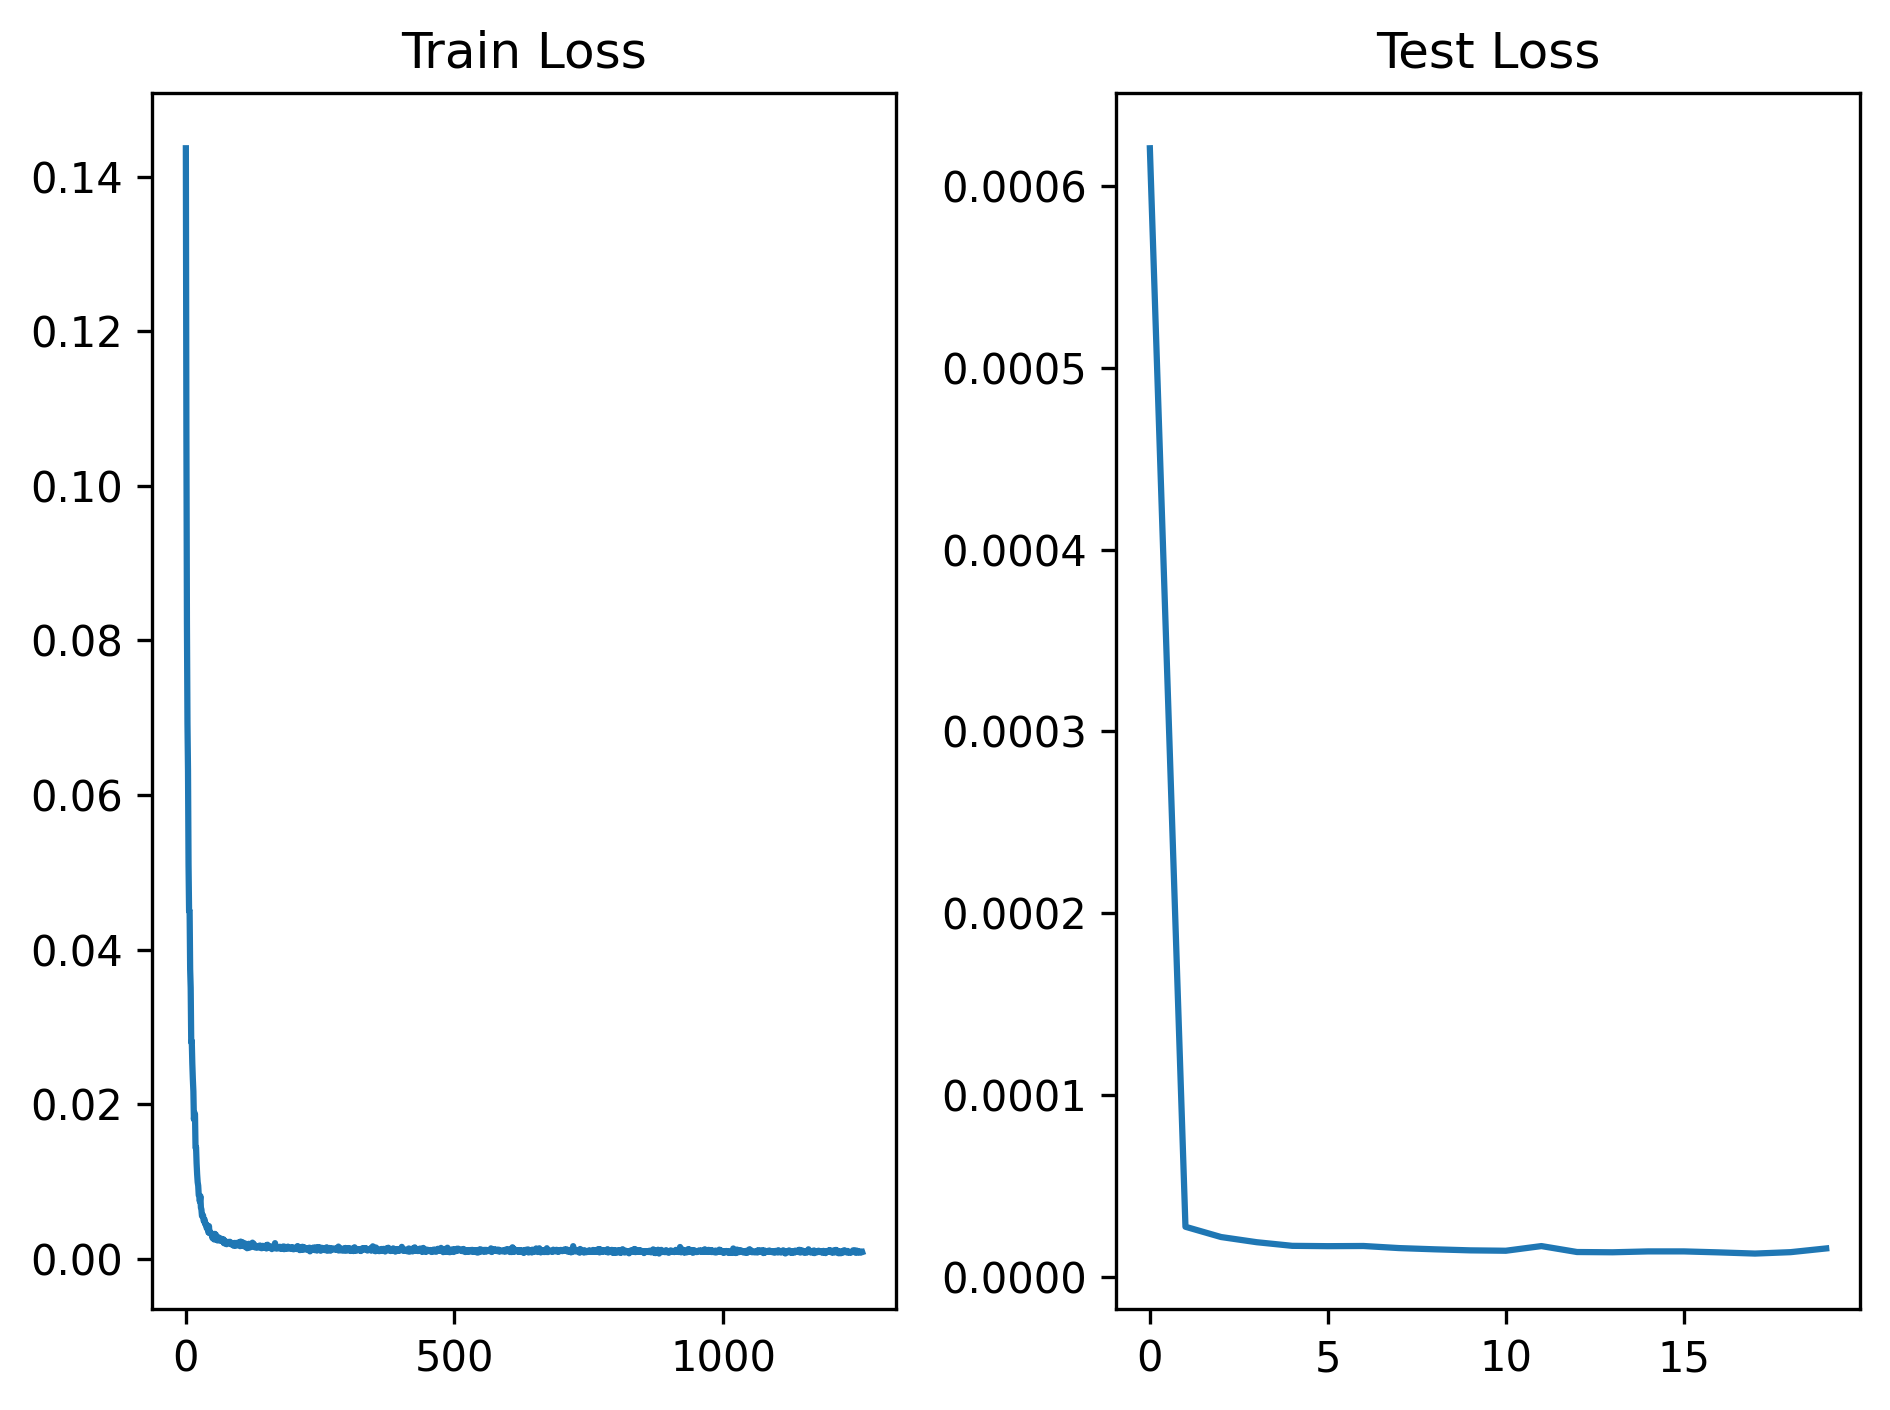

In [ ]:
fig, axs = plt.subplots(1, 2, dpi=300)
fig.set_tight_layout(True)

axs[0].plot(train_losses)
axs[0].title.set_text("Train Loss")
axs[1].plot(test_losses)
axs[1].title.set_text("Test Loss")

In [ ]:
test_idxs = np.random.choice(len(test_X))
y_pred = model(test_X[test_idxs].unsqueeze(0), threshold=0.1, weight=1.0)

print(y_pred.shape)

plt.subplot(2, 3, 1)
plt.imshow(test_X[test_idxs, 0, 0].cpu())
plt.subplot(2, 3, 2)
plt.imshow(test_X[test_idxs, 0, 1].cpu())
plt.subplot(2, 3, 3)
plt.imshow(y_pred.cpu().detach().squeeze(0).reshape(36, 36))
plt.subplot(2, 3, 4)
plt.imshow(test_X[test_idxs, 0, 0].cpu())
plt.subplot(2, 3, 5)
plt.imshow(test_X[test_idxs, 0, 1].cpu())
plt.subplot(2, 3, 6)
plt.imshow(test_y[test_idxs, 0].cpu().reshape(36, 36))
plt.show()

plt.imshow((test_y[test_idxs, 0].cpu() - y_pred.cpu().detach()).abs().reshape(36, 36))

NameError: name 'test_X' is not defined

/var/folders/jd/lb_vbvw54zd00wp54hlkx4_m0000gn/T/ipykernel_35398/4145797385.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  predicted_sequence[i] = model(X).cpu().detach().reshape(36, 36, 1)


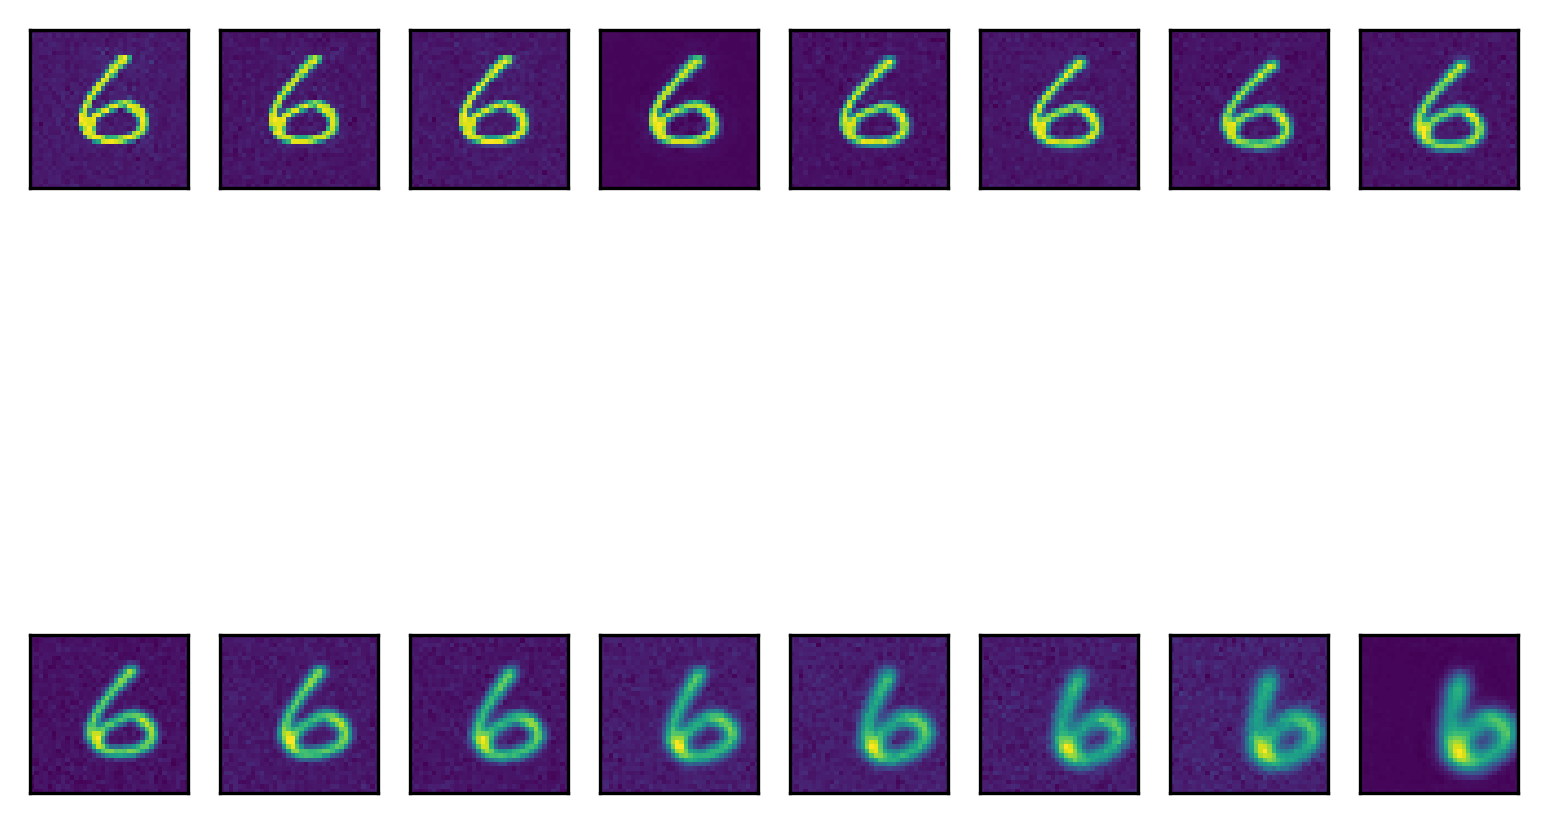

In [ ]:
model.eval()

idx = np.random.choice(len(n6))
test_sequence = n6[idx]

fig, axs = plt.subplots(2, 8, dpi=300)
predicted_sequence = np.copy(test_sequence)

predicted_sequence[3] = np.zeros((36, 36, 1))
predicted_sequence[15] = np.zeros((36, 36, 1))

for i in range(0, 16):
    if (predicted_sequence[i] == 0).all():
        X = (
            torch.tensor(predicted_sequence[i - 2 : i], dtype=torch.float32)
            .unsqueeze(0)
            .permute(0, 4, 1, 2, 3)
            .to(device)
        )
        predicted_sequence[i] = model(X).cpu().detach().reshape(36, 36, 1)
    axs[i // 8][i % 8].imshow(predicted_sequence[i])
    axs[i // 8][i % 8].set_xticks([])
    axs[i // 8][i % 8].set_yticks([])